In [ ]:
!pip install evaluate bert_score datasets rouge_score --upgrade transformers

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
from peft import LoraConfig, get_peft_model
import torch

# Load the dataset
ds = load_dataset("Suyogp/legal_summarizer_data")
train_dataset = ds["train"].filter(lambda x: x["summary"].strip() != "").remove_columns(["id"])
val_dataset   = ds["validation"].filter(lambda x: x["summary"].strip() != "").remove_columns(["id"])
test_dataset  = ds["test"].filter(lambda x: x["summary"].strip() != "").remove_columns(["id"])


# Load tokenizer and model
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, device_map="auto")

# LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q", "v", "k", "o", "wi", "wo"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

# Apply LoRA
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/618 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/80.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.25M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/10.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5623 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/703 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/703 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5623 [00:00<?, ? examples/s]

Filter:   0%|          | 0/703 [00:00<?, ? examples/s]

Filter:   0%|          | 0/703 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

trainable params: 2,310,144 || all params: 249,888,000 || trainable%: 0.9245


In [ ]:
train_dataset

Dataset({
    features: ['dialogue', 'summary'],
    num_rows: 5541
})

In [ ]:
def preprocess_data(examples):
    # Prompt format
    inputs = [f"Summarize the following legal case dialogue:\n{dialogue}" for dialogue in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=512, padding="max_length", truncation=True)

    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, padding="max_length", truncation=True)

    # Mask pad tokens in the labels
    model_inputs["labels"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]

    return model_inputs


In [ ]:
train_dataset = train_dataset.map(preprocess_data, batched=True)
val_dataset   = val_dataset.map(preprocess_data, batched=True)
test_dataset  = test_dataset.map(preprocess_data, batched=True)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)


Map:   0%|          | 0/5541 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Map:   0%|          | 0/694 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./legal_summary_model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=2,
    fp16=False,
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    label_names=["labels"],
    predict_with_generate=True  # ✅ Required for generation in evaluation
)



from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,

    data_collator=data_collator
)


<ipython-input-8-267be36b9cd6>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
trainer.train()


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
50,2.663700
100,2.742800
150,2.602900
200,2.618000
250,2.509400
300,2.527900
350,2.571900
400,2.570100
450,2.534400
500,2.472900


TrainOutput(global_step=2772, training_loss=2.499627885364351, metrics={'train_runtime': 1743.896, 'train_samples_per_second': 6.355, 'train_steps_per_second': 1.59, 'total_flos': 7667127300390912.0, 'train_loss': 2.499627885364351, 'epoch': 2.0})

In [ ]:
##before_finetunning##

def summarize_dialogue(dialogue_text):
    prompt = f"Summarize the following legal case dialogue:\n{dialogue_text}"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_length=150)
    summary = tokenizer.decode(output[0], skip_special_tokens=True)
    return summary
##Example test##
sample_dialogue =train_dataset["dialogue"][0]
print(test_dataset["summary"][0])
print(summarize_dialogue(sample_dialogue))

Token indices sequence length is longer than the specified maximum sequence length for this model (4431 > 512). Running this sequence through the model will result in indexing errors


In pursuance of a Housing Scheme the Tamil Nadu Housing Board, Madras had allotted residential plots over the land acquired under the Land Acquisition Act, to different groups of applicants including the low income group on terms and conditions stipulated in the lease deed Exh.
B 3 sometime in the year 1963.
After a lapse of more than a decade of the allotment, fresh demands were made from the allottees in 1975.
Objecting to the same, the respondent herein filed a suit for self and on behalf of all the allottees of low income group settled in the Colony named Ashok Nagar, pray ing for a permanent injunction restraining the Board from enforcing the demand.
The defendant Board questioned the very maintainability of the suit in a representative capacity and also pleaded that it was entitled to finally determine the correct prices for the plots after taking into account the final award of the compensation for acquired land and until then the prices were tentative.
The trial court negatived

In [ ]:
##after_finetunning##

def summarize_dialogue(dialogue_text):
    prompt = f"Summarize the following legal case dialogue:\n{dialogue_text}"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_length=150)
    summary = tokenizer.decode(output[0], skip_special_tokens=True)
    return summary

##Example test##
sample_dialogue = test_dataset["dialogue"][0]
print(test_dataset["summary"][0])
print(summarize_dialogue(sample_dialogue))

In pursuance of a Housing Scheme the Tamil Nadu Housing Board, Madras had allotted residential plots over the land acquired under the Land Acquisition Act, to different groups of applicants including the low income group on terms and conditions stipulated in the lease deed Exh.
B 3 sometime in the year 1963.
After a lapse of more than a decade of the allotment, fresh demands were made from the allottees in 1975.
Objecting to the same, the respondent herein filed a suit for self and on behalf of all the allottees of low income group settled in the Colony named Ashok Nagar, pray ing for a permanent injunction restraining the Board from enforcing the demand.
The defendant Board questioned the very maintainability of the suit in a representative capacity and also pleaded that it was entitled to finally determine the correct prices for the plots after taking into account the final award of the compensation for acquired land and until then the prices were tentative.
The trial court negatived

In [ ]:
model.save_pretrained("lora_legal_summarizer")
tokenizer.save_pretrained("lora_legal_summarizer")

('lora_legal_summarizer/tokenizer_config.json',
 'lora_legal_summarizer/special_tokens_map.json',
 'lora_legal_summarizer/spiece.model',
 'lora_legal_summarizer/added_tokens.json',
 'lora_legal_summarizer/tokenizer.json')

In [ ]:
from transformers import AutoModelForSeq2SeqLM

# Load base model (non-finetuned)
base_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base").to("cuda")
base_model.eval()

# Predict with base model
from tqdm import tqdm
def generate_summaries_base(model, dataset):
    summaries = []
    for i in tqdm(range(len(dataset))):
        input_text = f"Summarize the following legal case dialogue:\n{dataset[i]['dialogue']}"
        input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512).input_ids.to("cuda")
        output_ids = model.generate(input_ids, max_length=128, num_beams=4)
        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries

base_summaries = generate_summaries_base(base_model, test_dataset)


100%|██████████| 694/694 [25:15<00:00,  2.18s/it]


In [ ]:
def generate_summaries_tuned(model, dataset, tokenizer, max_input_len=512, max_output_len=128):
    model.eval()
    model.to("cuda")

    summaries = []
    for i in tqdm(range(len(dataset))):
        input_text = f"Summarize the following legal case dialogue:\n{dataset[i]['dialogue']}"
        inputs = tokenizer(
            input_text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=max_input_len
        ).to("cuda")

        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=max_output_len,
                num_beams=4
            )

        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        summaries.append(summary)

    return summaries

In [ ]:
lora_summaries = generate_summaries_tuned(model, test_dataset, tokenizer)

100%|██████████| 694/694 [52:46<00:00,  4.56s/it]


In [ ]:
import evaluate
rouge = evaluate.load("rouge")

# Get reference summaries
references = [x["summary"].strip() for x in test_dataset]

# Compute metrics
base_rouge = rouge.compute(predictions=base_summaries, references=references, use_stemmer=True)
lora_rouge = rouge.compute(predictions=lora_summaries, references=references, use_stemmer=True)
print(f"Base model Rouge: {base_rouge}")
print(f"Fine-tuned Model Rouge: {lora_rouge}")

Base model Rouge: {'rouge1': np.float64(0.09041803669423637), 'rouge2': np.float64(0.04266127788303077), 'rougeL': np.float64(0.06361865672864753), 'rougeLsum': np.float64(0.0820018255452267)}
Fine-tuned Model Rouge: {'rouge1': np.float64(0.16889430144006545), 'rouge2': np.float64(0.09577019451275676), 'rougeL': np.float64(0.11826824434160124), 'rougeLsum': np.float64(0.15403211897396096)}


In [26]:
# Load BERTScore metric
bertscore = evaluate.load("bertscore")

# Use the same references as before
references = [x["summary"].strip() for x in test_dataset]

# Compute BERTScore for both models
base_bertscore = bertscore.compute(predictions=base_summaries,
                                   references=references,
                                   lang="en")
lora_bertscore = bertscore.compute(predictions=lora_summaries,
                                   references=references,
                                   lang="en")

# Average F1 scores (most commonly used from BERTScore)
avg_base_f1 = sum(base_bertscore["f1"]) / len(base_bertscore["f1"])
avg_lora_f1 = sum(lora_bertscore["f1"]) / len(lora_bertscore["f1"])

print(f"Base model BERTScore (F1): {avg_base_f1:.4f}")
print(f"LoRA Fine-Tuned BERTScore (F1): {avg_lora_f1:.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model BERTScore (F1): 0.7988
LoRA Fine-Tuned BERTScore (F1): 0.8352


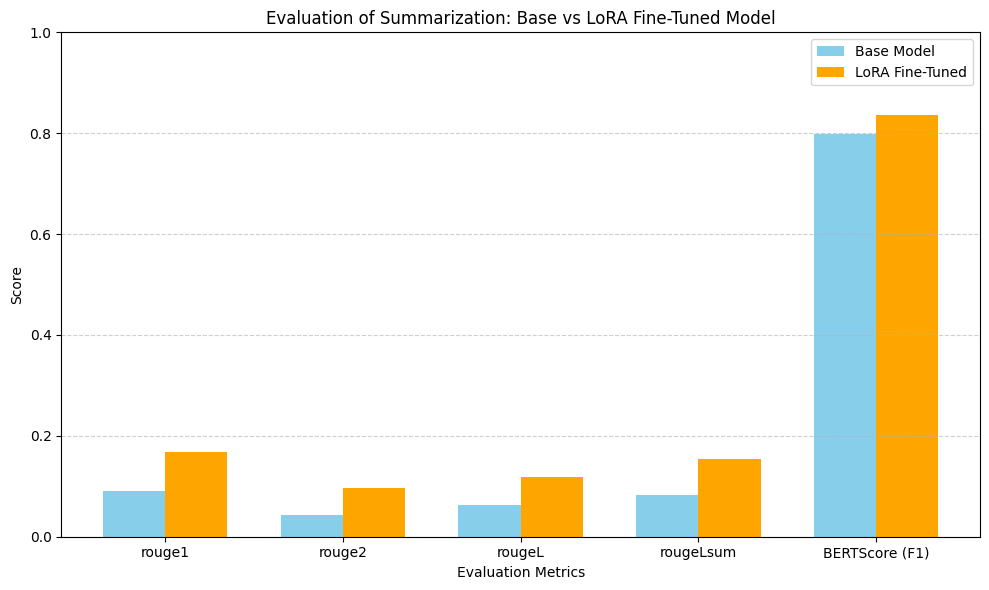

In [27]:
import matplotlib.pyplot as plt

# ROUGE metric names
labels = ["rouge1", "rouge2", "rougeL", "rougeLsum", "BERTScore (F1)"]

# Extract ROUGE scores
base_scores = [base_rouge[k] for k in labels[:-1]]
lora_scores = [lora_rouge[k] for k in labels[:-1]]


base_scores.append(avg_base_f1)
lora_scores.append(avg_lora_f1)


x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, base_scores, width=width, label='Base Model', color='skyblue')
plt.bar([p + width for p in x], lora_scores, width=width, label='LoRA Fine-Tuned', color='orange')

plt.xlabel('Evaluation Metrics')
plt.ylabel('Score')
plt.title('Evaluation of Summarization: Base vs LoRA Fine-Tuned Model')
plt.xticks([p + width / 2 for p in x], labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
from tabulate import tabulate

# Helper function to truncate long texts
# Helper function to truncate and wrap long texts for readability
def truncate(text, max_len=300, wrap_at=120,ty='none'):
    text = text.replace("\n", " ").strip()
    if len(text) > max_len and ty=='input':
        text = text[:max_len] + "..."
    # Wrap the text at 'wrap_at' characters per line
    return "\n".join([text[i:i+wrap_at] for i in range(0, len(text), wrap_at)])


# Choose how many test examples to compare
num_examples = 5  # change as needed

# Build comparison rows
rows = []
for i in range(num_examples):
    input_text = truncate(test_dataset[i]["dialogue"],ty='input')
    reference = truncate(test_dataset[i]["summary"],ty='input')
    base_summary = truncate(base_summaries[i])
    lora_summary = truncate(lora_summaries[i])

    rows.append({
        "Input": input_text,
        "Real Summary": reference,
        "Base Model Summary": base_summary,
        "LoRA Fine-Tuned Summary": lora_summary
    })

# Create DataFrame
df = pd.DataFrame(rows)

# Print as table in terminal
print(tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=True))

# Save as CSV (truncated)
df.to_csv("summary_comparison_truncated.csv", index=False)

# Save as Excel (better for long text)
df.to_excel("summary_comparison.xlsx", index=False)

# Save as readable .txt report
with open("summary_comparison.txt", "w", encoding="utf-8") as f:
    for i, row in df.iterrows():
        f.write(f"=== Example {i+1} ===\n")
        f.write(f"Input:\n{row['Input']}\n\n")
        f.write(f"Real Summary:\n{row['Real Summary']}\n\n")
        f.write(f"Base Model Summary:\n{row['Base Model Summary']}\n\n")
        f.write(f"LoRA Fine-Tuned Summary:\n{row['LoRA Fine-Tuned Summary']}\n")
        f.write("\n" + "="*50 + "\n\n")

╒════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│    │ Input                                                                                                                    │ Real Summary                                                                                                             │ Base Model Summary                                                                                                       │ LoRA Fine-Tuned Summary                                                                                                  │
╞═